In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()
print(tf.__version__)

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

2.7.0


In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

2021-12-19 00:01:47.085837: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-19 00:01:47.331246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
2021-12-19 00:01:47.333701: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 21.12M (22151168 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-12-19 00:01:47.334114: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 19.01M (19936256 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-12-19 00:01:47.334541: I tensorflo

KeyboardInterrupt: 

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2021-12-19 00:00:43.573780: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Well then, what is it?! I found Nicholson\'s character shallow and most unfortunately uninteresting. Angelica Huston\'s character drained my power. And Kathleen Turner is a filthy no good slut. It\'s not that I "don\'t get it". It\'s not that I don\'t think that some of the ideas could\'ve lead to something more. This is a film with nothing but the notion that we\'re supposed to accept these ideas, and that\'s what the movie has going for it. That Nicholson falls for Turner is absurd, but then again, it is intended to be so. This however does not strike me as a.)funny, or b.)...even remotely interesting!!! This was a waste of my time, so don\'t let the hype get the best of you...it is a waste of your time! With all that being said, the opening church sequence is quite beautiful...'
 b"The trailers for this film were better than the movie. What waste of talent and money. Wish I would've waited for this movie to come on DVD because at least I wouldn't be out $9. The movie tota

2021-12-19 00:00:43.895990: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [6]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

ValueError: Exception encountered when calling layer "text_vectorization" (type TextVectorization).

Expected nrows >= value_rowids[-1] + 1; got nrows=0, value_rowids[-1]=0

Call arguments received:
  • inputs=tf.Tensor(shape=(64,), dtype=string)

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"honestly, where can I begin! This was a low budget, HORRIBLY acted film, it was so cheesy it had us all bursting with laughter to how completely retarded it was! the sword fighting scenes weren't even sword fights, they were playing around with some plastic swords they bought at wal-mart and all they were doing was just moaning to try and make it look like they were struggling!! Me and my family was in the mood for a really good action movie one day, so we decided to go to the store and look for one, and there it was The Sawtooth Island movie. I mean it looked so great but when we watched it at home I practically died after the first scene.<br /><br />Oh and the plot of the film, the story board, the script, etc..was a bunch of garbage that I don't even know why the director and producer even wasted their time making it!! But if you happen to stumble upon this movie..do not get it!!!!!"
Round-trip:  [UNK] where can i begin this was a low budget [UNK] [UNK] film it was so c

In [7]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.build()
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [10]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 8s 20ms/step - loss: 0.3231 - accuracy: 0.8638
Test Loss: 0.32313272356987
Test Accuracy: 0.8637999892234802


(0.0, 0.6571094393730164)

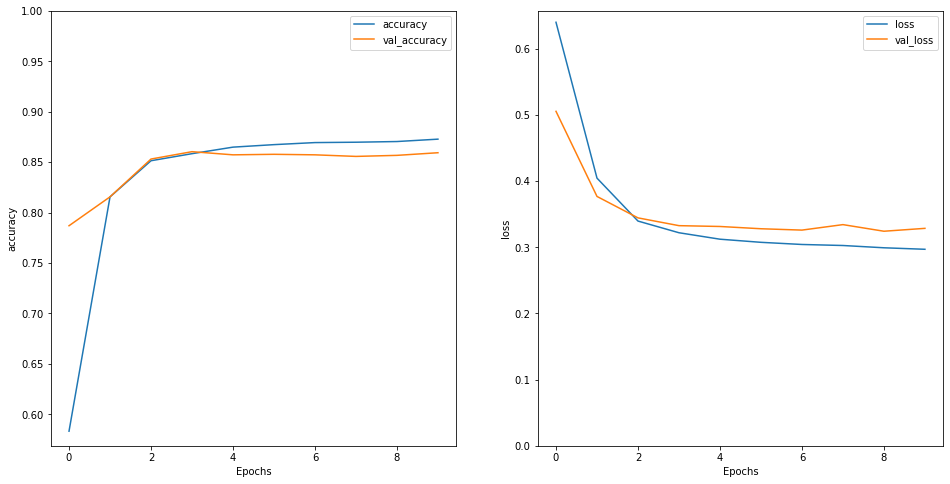

In [11]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_text = 'absolute trash'
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-0.02558486]]


[[0.96126163]]


In [11]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00361749]
